# Final Project Social Graphs & Interactions 

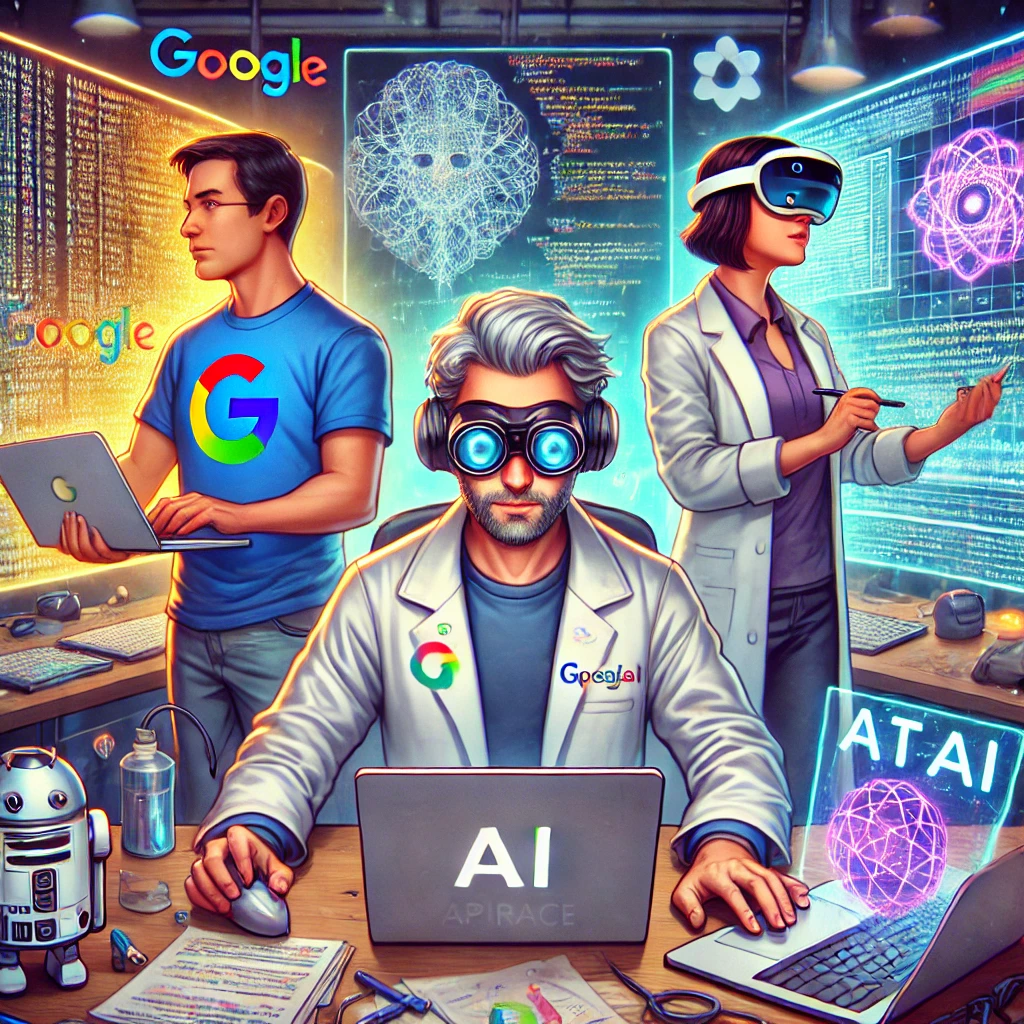

In [75]:
import IPython.display as display
display.Image(filename='pictures/ai_researchers.jpg', width=500, height=500)


## 0. Imports

In [44]:
! pip install jsonlines
import os
import jsonlines
import os
import json
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import requests
import time
import os
import json
import networkx as nx
import pickle
import cython
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import community as community_louvain
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import fa2_modified as fa2
import re
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import math
from wordcloud import WordCloud
import random
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: C:\Users\balda\anaconda3\python.exe -m pip install --upgrade pip


____


## 1. Data Collection

Our goal is to build a graph of all relevant AI research papers. To do so, we need to collect relevant metadata. We are using arxiv as our primary source for papers, and take the subcategory "cs.AI" as a baseline. As of 11.12.2024, this category contained around 108.000 papers.

The arxiv API is relatively strict about rate limits, and we run into consistency issues multiple times when creating files by accessing the arxiv API. Thus, we created a more stable workflow, leveraging the weekly updated arxiv metadata snapshot on Kaggle (https://www.kaggle.com/datasets/Cornell-University/arxiv) as well as the Semantic Scholar API (https://api.semanticscholar.org/graph/v1/paper/search).

First, we download the arxiv metadata snapshot from Kaggle and create one empty json file for each paper in the cs.AI category. Then, we contact the Semantic Scholar API to get the metadata for each paper. As the Semantic Scholar API also has rate limits, we used exponential backoff to avoid overloading the API. In total, the script run for ~25 hours and created 108.111 json files.

We have uploaded examplary json files to the repository to illustrate the data structure, but commented out the code. To properly re-run the script and to create all empty json files, downloading the Kaggle snapshot (4.45GB) into the current repository is necessary.

#### 1.1. Creating empty json files from arxiv metadata snapshot


In [ ]:
# function to create empty json files from the arxiv metadata snapshot
def create_json_from_arxiv():
    output_dir = "papers/metadata"
    os.makedirs(output_dir, exist_ok=True)
    counter = 0
    folder = 0

    # read arxiv metadata
    with jsonlines.open('arxiv-metadata-oai-snapshot.json') as reader:
        for article in reader:
            # check if paper is in the right category
            categories = article.get('categories').split()

            if 'cs.AI' in categories:
                # jump to next folder every 10k papers
                if counter % 10000 == 0:
                    folder += 1
                    output_dir = f"papers/metadata/{folder}"
                    os.makedirs(output_dir, exist_ok=True)

                # clean arxiv id
                clean_arxiv_id = article.get('id').split('v')[0]

                # Create empty file with cleaned arXiv ID
                paper_id = clean_arxiv_id.replace('/', '_')  # Replace slashes with underscores
                output_path = os.path.join(output_dir, f'{paper_id}.json')

                # Create an empty file
                with open(output_path, 'w') as file:
                    pass  # This creates an empty file

                counter += 1
        
                if counter % 10000 == 0:
                    print(f"Processed {counter} papers")
    print(counter)

#create_json_from_arxiv()

____

#### 1.2. Fetching metadata from Semantic Scholar API

In [ ]:
# function to fetch metadata from Semantic Scholar API for one paper
def fetch_metadata(arxiv_id, max_retries, initial_delay):
    url = f"https://api.semanticscholar.org/v1/paper/arXiv:{arxiv_id}"
    
    for attempt in range(max_retries):
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:  # Too Many Requests
            delay = initial_delay * (2 ** attempt)  # Exponential backoff
            print(f"Rate limit hit, waiting {delay} seconds...")
            time.sleep(delay)
            continue
        else:
            print(f"Failed :{arxiv_id}. Status code: {response.status_code}, Response: {response.text}")
            return None
    
    print(f"Max retries exceeded for {arxiv_id}")
    return None

In [ ]:
# function to fetch metadata from Semantic Scholar API for all papers in a folder
def process_files(metadata_dir, max_workers):
    files = os.listdir(metadata_dir)
    total_files = len(files)
    
    # Track successful and failed papers
    successful = []
    failed = []
    
    # Create progress bar
    pbar = tqdm(
        total=total_files,
        desc="Fetching metadata",
        unit="papers"
    )
    
    def process_and_update(file):
        try:
            arxiv_id = file.replace('_', '/').replace('.json', '')
            response = fetch_metadata(
                arxiv_id,
                max_retries=10,     
                initial_delay=2     
            )
            
            if response:
                with open(os.path.join(metadata_dir, file), 'w') as f:
                    json.dump(response, f, indent=4)
                successful.append(arxiv_id)
            else:
                failed.append(arxiv_id)
                
            pbar.update(1)
            
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            failed.append(file)
            pbar.update(1)
    
    # Process files in parallel to speed up the process
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_and_update, file) for file in files]
        for future in futures:
            future.result()
    
    pbar.close()
    
    # Save progress report
    report = {
        'total_processed': len(files),
        'successful': len(successful),
        'failed': len(failed),
        'failed_ids': failed
    }
    
    with open('fetch_report.json', 'w') as f:
        json.dump(report, f, indent=4)
    
    print(f"\nProcessing complete!")
    print(f"Successfully processed: {len(successful)}")
    print(f"Failed: {len(failed)}")
    if failed:
        print("Failed IDs saved to fetch_report.json")

In [ ]:
# calling the function for each folder (each folder contains 10k papers)

for i in range(1, 12):
    #process_files(f'papers/metadata_lg/{i}', max_workers=2)
    continue

We have now successfully iterated through our 108k json files which we have created in the previous step. Error rates were constant at around 0.5% per folder, with most errors relating to the Semantic Scholar API not being able to find the paper. We will ignore those empty files in the next steps.

____

## 2. Building the graph

We are using the created data structure to build a graph where each node is a researcher, and each edge is a collaboration on a paper. Again, we have commented out this code, and attached a pickle file to the repository to enable re-running of the paper without access to the 108k json files.

#### 2.1. Adding nodes and edges


In [ ]:
# function to add a paper to the graph and edges between authors for collaborations
def add_paper_to_graph(graph, paper):
    # Extract author names (handle both list of strings and list of dicts)
    authors_raw = paper.get("authors", [])
    authors = []
    for author in authors_raw:
        if isinstance(author, dict) and "name" in author:
            authors.append(author["name"])
        elif isinstance(author, str):
            authors.append(author)

    arxiv_id = paper.get("arxivId", "Unknown Arxiv ID")
    title = paper.get("title", "Unknown Title")
    
    # Add nodes and update their attributes
    for author in authors:
        if author not in graph:
            graph.add_node(author, papers=[])
        # Add this paper (arxivId, title) to the author's list of papers
        graph.nodes[author]["papers"].append((arxiv_id, title))
    
    # Add edges for each pair of authors in the paper
    for i, author1 in enumerate(authors):
        for j, author2 in enumerate(authors):
            if i >= j:  # Avoid adding self-loops and duplicate edges
                continue
            
            # Add edge with paper attributes
            graph.add_edge(author1, author2, 
                           title=title,
                           year=paper.get("year"),
                           authors=authors,
                           doi=paper.get("doi"),
                           fieldsOfStudy=paper.get("fieldsOfStudy"),
                           influencialCitationCount=paper.get("influencialCitationCount"),
                           isOpenAccess=paper.get("isOpenAccess"),
                           numCitedBy=paper.get("numCitedBy"),
                           numCiting=paper.get("numCiting"),
                           arxivId=arxiv_id,
                           paperId=paper.get("paperId"),
                           abstract=paper.get("abstract"))

In [ ]:
G = nx.MultiGraph()

# Path to the directory containing JSON files
directory_path = "papers/metadata"

skipped_counter = 0
# Iterate through all JSON files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".json"):
        file_path = os.path.join(directory_path, filename)
        with open(file_path, "r") as file:
            try:
                # Load JSON
                paper = json.load(file)
                
                # Skip empty JSON objects
                if not paper:
                    print(f"Skipping file {file_path}: Empty JSON file.")
                    continue
                
                add_paper_to_graph(G, paper)
            except json.JSONDecodeError:
                skipped_counter += 1
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

In [5]:
print(f"Graph has {len(G.nodes)} nodes and {len(G.edges)} edges.")

Graph has 192480 nodes and 2391299 edges.


____

#### 2.2. Extract Giant Connected Component



In [8]:
# Identify self-loops in the graph
self_loops = [(u, v, k) for u, v, k in G.edges(keys=True) if u == v]

# Remove the self-loops
G.remove_edges_from(self_loops)

print("\nSelf-loops have been removed.")


Self-loops have been removed.


In [9]:
connected_components = list(nx.connected_components(G))

# Identify the largest connected component (the giant component)
giant_component = max(connected_components, key=len)

# Create a subgraph for the giant component
giant_subgraph = G.subgraph(giant_component).copy()

# Print some statistics about the giant component
print(f"Giant component has {len(giant_subgraph.nodes)} nodes and {len(giant_subgraph.edges)} edges.")

Giant component has 162972 nodes and 2338729 edges.


This Giant Component is the graph we want to work with. We have added a pickle file to the repository to enable re-running of the paper without access to the 108k json files by running the following code:


In [2]:
# Path to pickle file
pickle_file_path = "pickles/researchers_csai_graph_gcc_with_abstract.pkl"

with open(pickle_file_path, "rb") as f:
    G = pickle.load(f)

# Confirm dimensions of GCC and graph from pickle file
print(f"Graph created from pickle has {len(G.nodes)} nodes and {len(G.edges)} edges.")

Graph created from pickle has 162972 nodes and 2338729 edges.


____

#### 2.3. Removing papers with low number of citations

Currently, our network is pretty large. We want to focus on relevant research papers. We are using the edge attribute "numCitedBy" to remove papers with less than 25 citations.

In [3]:
# Find edges with below 25 citations
edges_to_remove = [
    (u, v) for u, v, edge_data in G.edges(data=True) if edge_data.get("numCitedBy", 0) < 25
]

# # Copy graph and remove edges
G_filtered = G.copy()
G_filtered.remove_edges_from(edges_to_remove)

In [4]:
connected_components = list(nx.connected_components(G_filtered))

# Identify the largest connected component (the giant component)
giant_component = max(connected_components, key=len)

# Create a subgraph for the giant component
RG = G_filtered.subgraph(giant_component).copy()

In [5]:
print(f'Filtered graph has {len(RG.nodes())} nodes')
print(f'Filtered graph has {len(RG.edges())} edges')

Filtered graph has 39314 nodes
Filtered graph has 1015840 edges


In [6]:
# Set to store unique titles
unique_titles = set()

# Iterate over all edges in the RG graph
for _, _, edge_data in RG.edges(data=True):
    # Access the title
    title = edge_data.get('title', None)
    
    # Ensure the title is valid and add it to the set
    if title:
        unique_titles.add(title)

# Number of unique papers (deduplicated edges)
num_unique_papers = len(unique_titles)

print(f"Number of unique papers: {num_unique_papers}")

Number of unique papers: 26709


____

#### 2.4. Adding Citations as node features

Currently, only the edges representing the papers have a citation count. We want to add the citation count as a node feature for each node.

In [7]:
# Dictionary to store citation counts for each researcher (node)
researcher_citations = defaultdict(int)

# Dictionary to track papers already counted for each researcher (to avoid duplicates)
researcher_papers = defaultdict(set)

# Iterate over all edges in the graph
for u, v, edge_data in G.edges(data=True):
    # Access the title and citation count
    title = edge_data.get('title', None)
    num_cited_by = edge_data.get('numCitedBy', 0)  # Default to 0 if not present
    
    # Ensure title is valid
    if title:
        # For researcher u
        if title not in researcher_papers[u]:
            researcher_citations[u] += num_cited_by
            researcher_papers[u].add(title)
        
        # For researcher v
        if title not in researcher_papers[v]:
            researcher_citations[v] += num_cited_by
            researcher_papers[v].add(title)

# Now researcher_citations contains total citation count for each researcher (node)
# Add the citations feature to each node in the graph
for researcher, total_citations in researcher_citations.items():
    if researcher in G.nodes:
        G.nodes[researcher]['citations'] = total_citations  # Add 'citations' feature to the node

In [8]:
# Dictionary to store citation counts for unique papers (deduplicated by title)
unique_paper_citations = {}

# Iterate over all edges in the graph to extract citation data
for u, v, edge_data in G.edges(data=True):
    title = edge_data.get('title')
    num_cited_by = edge_data.get('numCitedBy', 0)  # Default to 0 if not present
    
    if title:  # Ensure the title is valid
        # If the title is not already in the dictionary, add it with its citation count
        if title not in unique_paper_citations:
            unique_paper_citations[title] = num_cited_by

# Extract citation counts for the unique papers
deduplicated_citation_counts = list(unique_paper_citations.values())

_____

#### 2.5. Converting MultiGraph to Regular Graph for later part of the analysis

In [9]:
def multigraph_to_weighted_graph(multigraph):
    # Dictionary to store weights for edges in the new graph
    edge_weights = defaultdict(lambda: defaultdict(int))

    # Iterate through all edges in the MultiGraph
    for u, v, edge_data in multigraph.edges(data=True):
        title = edge_data.get("title")
        num_cited_by = edge_data.get("numCitedBy", 0)

        # Ensure we consider unique papers by `title`
        if title:
            # Add the citation count to the edge weight for the (u, v) edge, using the title as a key
            edge_weights[(u, v)][title] = num_cited_by

    # Create a new regular graph
    weighted_graph = nx.Graph()

    # Add weighted edges to the new graph
    for (u, v), title_dict in edge_weights.items():
        # Sum up the citations for all unique papers between u and v
        total_weight = sum(title_dict.values())
        weighted_graph.add_edge(u, v, weight=total_weight)

    return edge_weights, weighted_graph

In [10]:
edge_weights, weighted_RG = multigraph_to_weighted_graph(RG)
RG_regular = nx.Graph(RG)

print(f'RG Multigraph: \n Nodes: {len(RG.nodes())}\n Edges: {len(RG.edges())}\n')
print(f'RG Regular: \n Nodes: {len(RG_regular.nodes())}\n Edges: {len(RG_regular.edges())}')

RG Multigraph: 
 Nodes: 39314
 Edges: 1015840

RG Regular: 
 Nodes: 39314
 Edges: 942607


___

## 3. Analyzing nodes (researchers) and edges (papers)

First, we want to create a good understanding of our graph by looking at some standard statistics and calculating some first insights about the AI researchers represented in our network. We'll start by looking into the scale-free properties of our graph.

#### 3.1. Degree Distribution


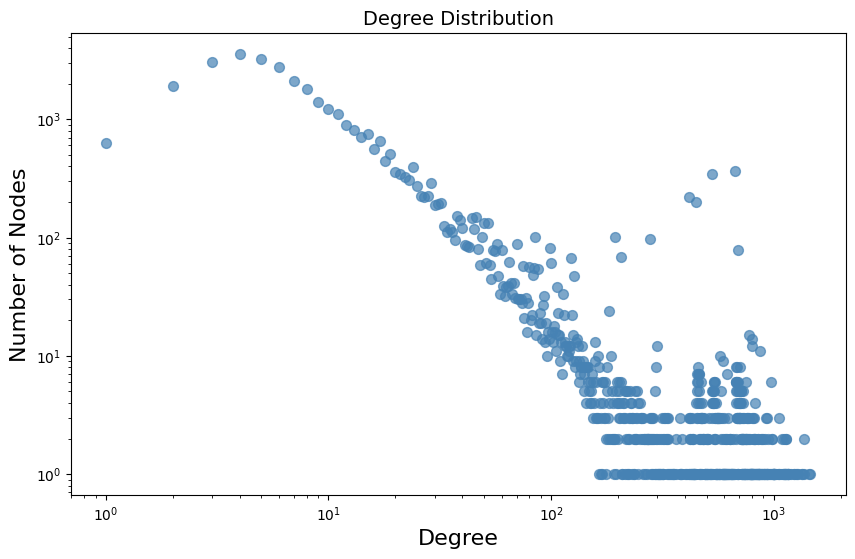

In [11]:
# Get the degree of each node
degrees = [d for _, d in RG.degree()]

# Count the frequency of each degree
degree_counts = {}
for degree in degrees:
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# Prepare data for plotting
degrees = list(degree_counts.keys())
counts = list(degree_counts.values())

# Plot the degree distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, counts, color="steelblue", alpha=0.7, s=50, label="Degree Count")

# Set both axes to log scale
plt.xscale("log")
plt.yscale("log")

# Title and labels
plt.title("Degree Distribution", fontsize=14)
plt.xlabel("Degree", fontsize=16)
plt.ylabel("Number of Nodes", fontsize=16)

# Show the plot
plt.show()

We are dealing with a scale-free network, this means that the degree distribution follows a power law. This is a good property, as it means that the network is not too clustered and that the network is not too sparse. In the context of AI research, this means that there are a few researchers with a very high number of citations, and most researchers have a relatively low number of citations, which is more or less what we have expected.

Let's print out the top 10 researchers by degree:

In [13]:
# Compute the degrees of all nodes
degrees = dict(RG.degree())

# Sort nodes by degree in descending order
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 nodes
top_10_nodes = sorted_degrees[:10]

# Display results
print("Top 10 nodes with highest degree:\n")
for node, degree in top_10_nodes:
    print(f"{node} - {degree}")

Top 10 nodes with highest degree:

Siamak Shakeri - 1462
Noah Fiedel - 1439
O. Vinyals - 1368
Ambrose Slone - 1368
Behnam Neyshabur - 1366
D. Hassabis - 1347
Michael B. Chang - 1344
Andrew M. Dai - 1285
Ethan Dyer - 1268
Vedant Misra - 1262


____

#### 3.2. Unique Neighbor Degree Distribution

The definition of our graph allows for multiple edeges between the same researchers (if they have collaborated on multiple papers). Let's investigate how much influence this has on the scale-free properties of our graph.

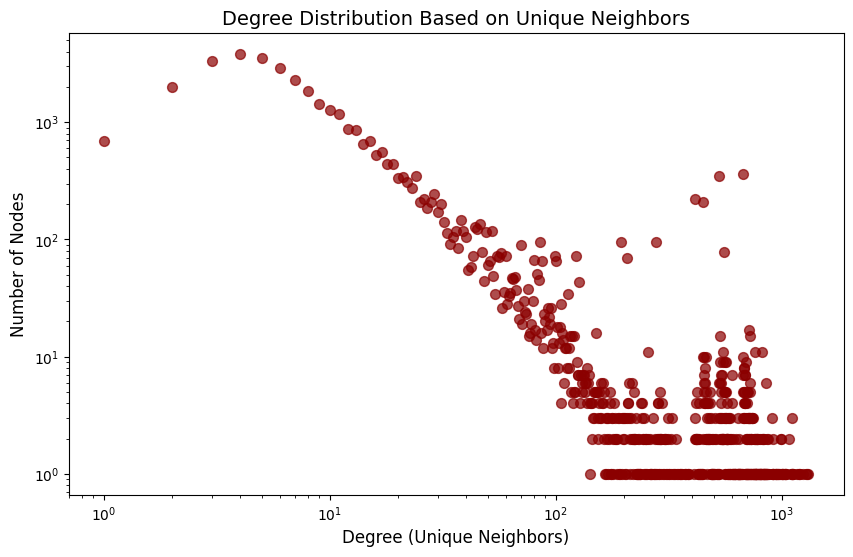

In [14]:
# Calculate degree based on unique neighbors
unique_neighbor_degrees = {node: len(set(RG.neighbors(node))) for node in RG.nodes()}

# Count the frequency of each degree
degree_counts = {}
for degree in unique_neighbor_degrees.values():
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# Prepare data for plotting
degrees = list(degree_counts.keys())
counts = list(degree_counts.values())

# Plot the degree distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, counts, color="darkred", alpha=0.7, s=50, label="Degree Count (Unique Neighbors)")

# Set both axes to log scale
plt.xscale("log")
plt.yscale("log")

# Title and labels
plt.title("Degree Distribution Based on Unique Neighbors", fontsize=14)
plt.xlabel("Degree (Unique Neighbors)", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)

# Show the plot
plt.show()

As we can see, also our network based on unique neighbors follows a power law. This means that the design choice of whether or whether not to consider multiple edges does not influence the scale-free properties of our graph.

Again, let's print out the top 10 researchers by unique neighbor degree:


In [15]:
# Compute the number of unique neighbors for each node
unique_neighbors = {node: len(set(RG.neighbors(node))) for node in RG.nodes()}

# Sort nodes by the number of unique neighbors in descending order
sorted_unique_neighbors = sorted(unique_neighbors.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 nodes
top_10_nodes = sorted_unique_neighbors[:10]

# Display results
print("Top 10 nodes with the highest unique neighbor degree:\n")
for node, count in top_10_nodes:
    print(f"{node} - {count}")

Top 10 nodes with the highest unique neighbor degree:

Siamak Shakeri - 1311
Noah Fiedel - 1297
Behnam Neyshabur - 1283
Ambrose Slone - 1241
Andrew M. Dai - 1210
Ethan Dyer - 1193
Vedant Misra - 1191
Luheng He - 1171
Harsh Mehta - 1122
Rosanne Liu - 1119


____

#### 3.3. Distribution of Citations across Research Papers

More important than the highly collaborative researchers are however the researchers that have published relevant papers. We use citations as a proxy for relevance. First, let's look at the distribution of citations across the papers in our graph:

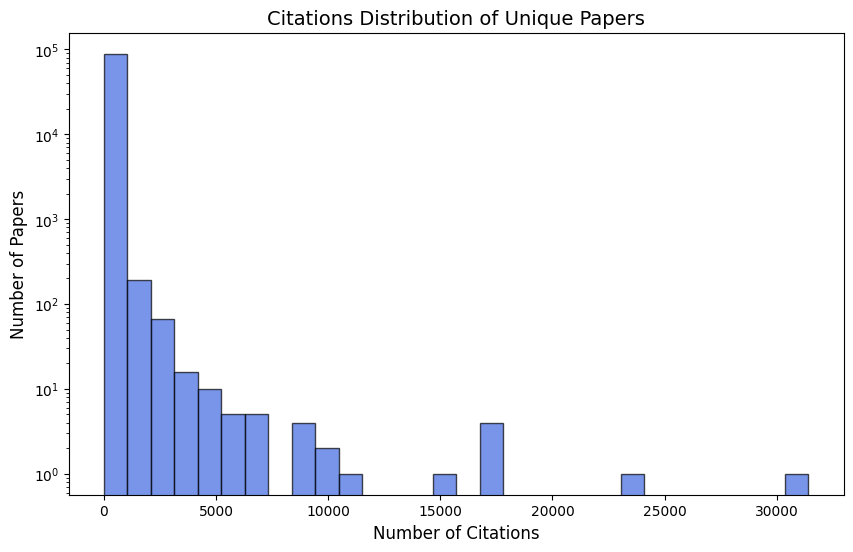

In [23]:
# Plotting the citation counts for unique papers
plt.figure(figsize=(10, 6))
plt.hist(
    deduplicated_citation_counts,
    bins=30,
    color="royalblue",
    alpha=0.7,
    edgecolor="black"
)

plt.yscale("log")  # Set y-axis to logarithmic scale

plt.title("Citations Distribution of Unique Papers", fontsize=14)
plt.xlabel("Number of Citations", fontsize=12)
plt.ylabel("Number of Papers", fontsize=12)

plt.show()

Distribution is clearly very skewed and exhibits exponential relationship between number of papers and citations. Most papers have a small number of citations often not even reaching a double digit figure.

Let's take a loot at the top 10 most relevant papers in our graph:

In [24]:
# Extract deduplicated citation data and associated paper metadata
deduplicated_paper_citations = [
    (title, citation_count) for title, citation_count in unique_paper_citations.items()
]

# Sort papers by citation count in descending order
sorted_deduplicated_papers = sorted(
    deduplicated_paper_citations, key=lambda x: x[1], reverse=True
)

# Get the top 10 papers
top_10_papers = sorted_deduplicated_papers[:10]

# Print the top 10 papers
print("Top Papers with Most Citations (Deduplicated by Title):\n")
for i, (title, citations) in enumerate(top_10_papers, 1):
    print(f"{i}. {title} - Citations: {citations}")

Top Papers with Most Citations (Deduplicated by Title):

1. An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale - Citations: 31414
2. SMOTE: Synthetic Minority Over-sampling Technique - Citations: 23278
3. A Unified Approach to Interpreting Model Predictions - Citations: 17703
4. Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification - Citations: 17689
5. Graph Attention Networks - Citations: 17607
6. Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization - Citations: 17416
7. “Why Should I Trust You?”: Explaining the Predictions of Any Classifier - Citations: 15069
8. Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks - Citations: 10801
9. Conditional Generative Adversarial Nets - Citations: 9774
10. Training language models to follow instructions with human feedback - Citations: 9614


<mark>to-do: interpretation</mark>  

____

#### 3.4. Distribution of Researchers by Citations

After analyzing the distribution of citations across the papers in our graph, we want to take a look at the distribution of citations across the researchers in our graph. We are calculating a depuplicated citation count for each researcher by summing up the citations of all the papers they have collaborated on. Papers that occur on multiple edges of the same author (if more than two authors collaborated on that paper) are only counted once.


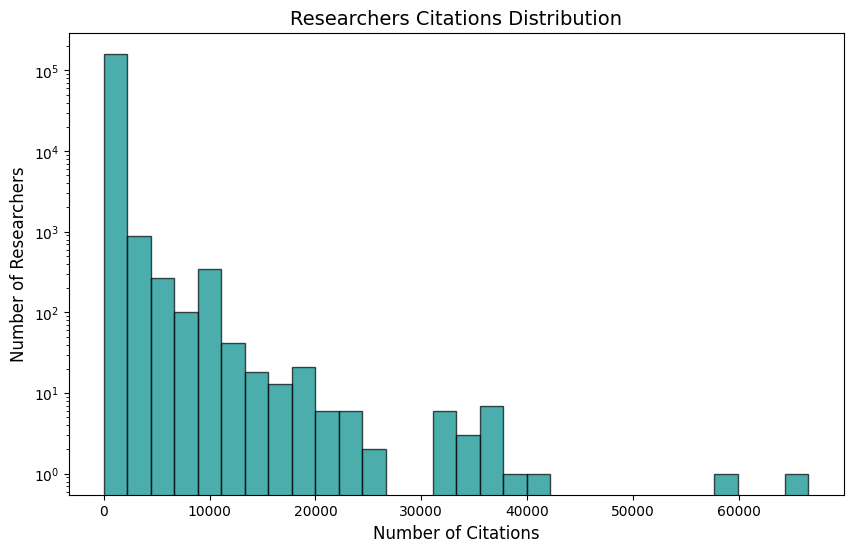

In [25]:
# Extract citation counts for each researcher (node)
researcher_citation_counts = [G.nodes[node].get('citations', 0) for node in G.nodes]

# Plotting the citation counts
plt.figure(figsize=(10, 6))
plt.hist(
    researcher_citation_counts,
    bins=30,
    color="darkcyan",
    alpha=0.7,
    edgecolor="black"
)

plt.yscale("log")  # Set y-axis to logarithmic scale

plt.title("Researchers Citations Distribution", fontsize=14)
plt.xlabel("Number of Citations", fontsize=12)
plt.ylabel("Number of Researchers", fontsize=12)

plt.show()

Just like in case of papers the distribution for researchers is similar. Most reasearchers seem to enjoy a relatively low number of citations with only a few most prominent ones reaching levels of even 60 thousand citations.

Again, let's print out the top 10 researchers by citation count:

In [28]:
# Sort researchers by total citations (descending)
sorted_researcher_citations = sorted(researcher_citations.items(), key=lambda x: x[1], reverse=True)

# Print the top researchers by total citations
print("Top Researchers by Total Citations (Using Node Property):\n")
for i, (researcher, total_citations) in enumerate(sorted_researcher_citations[:10], 1):
    print(f"{i}. {researcher} - Total Citations: {total_citations}")

Top Researchers by Total Citations (Using Node Property):

1. S. Levine - Total Citations: 66585
2. P. Abbeel - Total Citations: 59345
3. Alexey Dosovitskiy - Total Citations: 41593
4. Quoc V. Le - Total Citations: 38176
5. Lucas Beyer - Total Citations: 36650
6. Xiaohua Zhai - Total Citations: 36520
7. N. Houlsby - Total Citations: 36510
8. Alexander Kolesnikov - Total Citations: 36492
9. Mostafa Dehghani - Total Citations: 36346
10. Yoshua Bengio - Total Citations: 36330


## 4. Component Analysis

## 5. Community Analysis

#### 5.1. Detecting Node-Based Communities with Louvain Algorithm

For this part of the analysis, we are using the Regular Graph (RG_regular) that we have created in chapter 2.5. First, we need to load a partition file (included as pickle) to make sure we generate a reproducable community structure. We have produced the partition file by running the Louvain algorithm on the giant component of our graph.

In [52]:
# Set random_state (seems to be behaving differently on notebook reset)
random_state = 2000

# Find the best partition (communities)
partition = community_louvain.best_partition(RG_regular, random_state=random_state)

# Calculate the modularity of the partition
modularity = community_louvain.modularity(partition, RG_regular)

# Print the modularity score
print(f"Modularity: {modularity}")

Modularity: 0.7639564691162807


The modularity is very high meaning that researchers tend to form close collaboration hubs.

In [29]:
# Load partition to make sure it is running on the correct split
with open("pickles/partition.pkl", "rb") as file:
    partition = pickle.load(file)

In [30]:
# Group nodes by community
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

# Calculate the total number of communities and average number of nodes
num_communities = len(communities)
node_counts = [len(nodes) for nodes in communities.values()]
average_nodes_per_community = sum(node_counts) / num_communities if num_communities > 0 else 0

# Print the summary
print(f"Total number of communities: {num_communities}")
print(f"Average number of nodes per community: {average_nodes_per_community:.2f}")

Total number of communities: 73
Average number of nodes per community: 538.55


The algorithm has detected 73 communities with an average of 538.55 nodes per community. 
____

#### 5.2. Identifying Relevant Communities

Within these 73 communities, we want to identify the communities that are most relevant to our research question. 

To identify the most relevant communities for our research question, we will analyze three key metrics. First, we will look at the size of each community, measured by the number of researchers it contains. This will help us identify the major research clusters in the field. Second, we will examine the modularity contribution of each community, which measures how internally connected the community is compared to its external connections. A high modularity score suggests that researchers within the community collaborate more frequently with each other than with researchers outside the community, potentially indicating a cohesive research subfield. Third, we will calculate the average number of citations per researcher within each community. This metric helps us assess the academic impact and influence of different communities.

**A. Largest Communities**


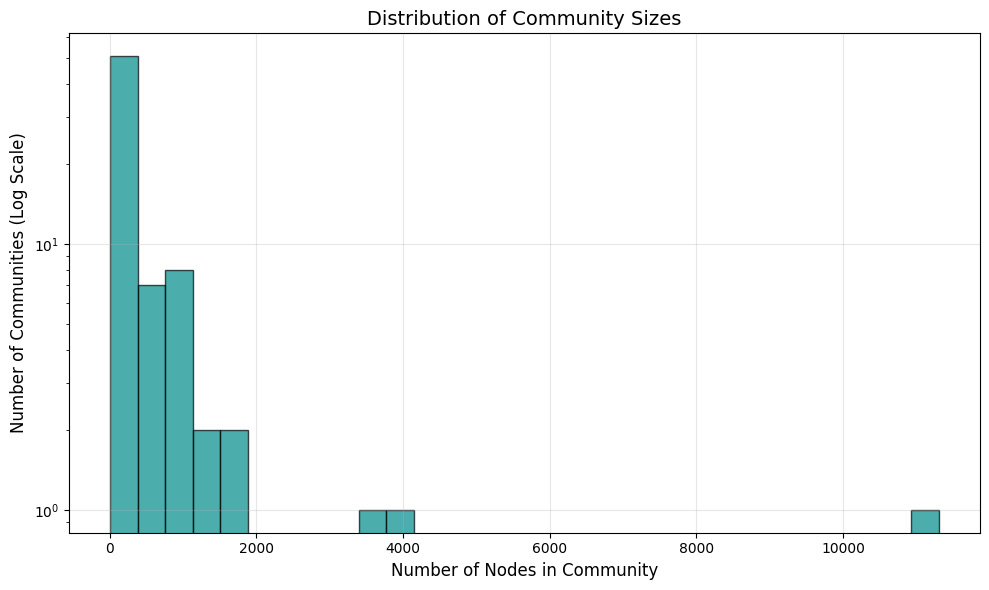

In [31]:
# Get community sizes
community_sizes = [len(nodes) for _, nodes in communities.items()]

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(
    community_sizes, 
    bins=30,
    color="darkcyan",
    alpha=0.7,
    edgecolor="black"
)

# Set y-axis to logarithmic scale since community sizes often follow power law
plt.yscale("log")

# Add labels and title
plt.title("Distribution of Community Sizes", fontsize=14)
plt.xlabel("Number of Nodes in Community", fontsize=12)
plt.ylabel("Number of Communities (Log Scale)", fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
# Sort communities by size in descending order
sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)

# Print the 5 largest communities
print("Communities with highest # nodes, descending:")
print("")
for i, (comm_id, nodes) in enumerate(sorted_communities[:10], 1):
    print(f"{i}. Community {comm_id}: {len(nodes)} nodes")

Communities with highest # nodes, descending:

1. Community 1: 11302 nodes
2. Community 0: 3910 nodes
3. Community 9: 3575 nodes
4. Community 21: 1878 nodes
5. Community 10: 1549 nodes
6. Community 60: 1375 nodes
7. Community 28: 1194 nodes
8. Community 42: 1124 nodes
9. Community 6: 1104 nodes
10. Community 31: 1059 nodes


**B. Highest Modularity Contribution**

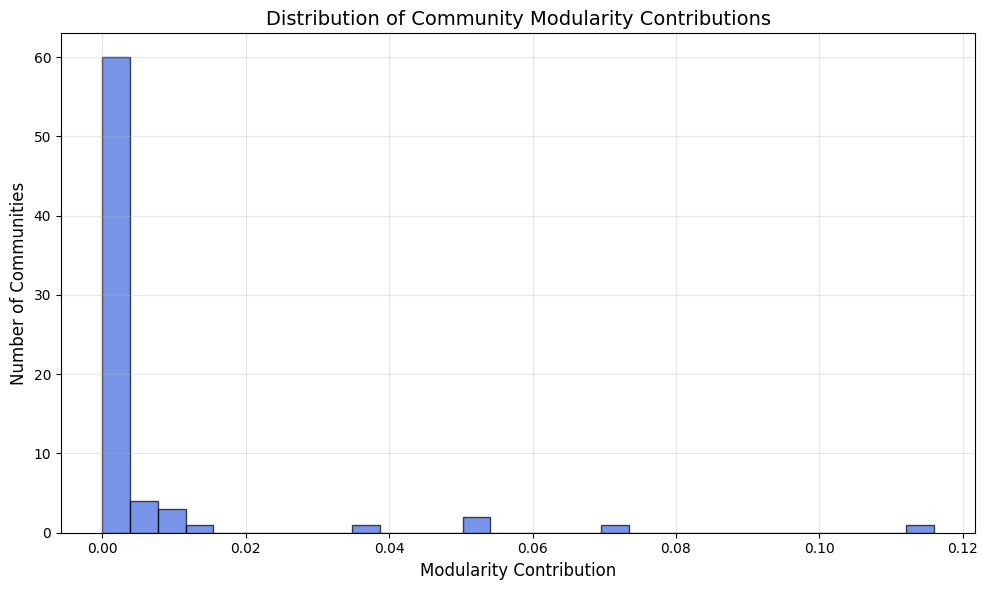

In [33]:
# Calculate modularity contribution for each community
community_modularity_contribution = {}
for comm_id, nodes in communities.items():
    # Get all edges between nodes in this community
    internal_edges = RG_regular.subgraph(nodes).edges()
    internal_edges_count = len(internal_edges)
    
    # Get all edges connected to nodes in this community
    total_edges = sum(RG_regular.degree(node) for node in nodes)
    
    # Calculate modularity contribution
    # Q_i = (internal edges / total edges) - (total degree / (2 * total edges))^2
    m = RG_regular.number_of_edges()
    modularity_contribution = (internal_edges_count / (2 * m)) - (total_edges / (4 * m))**2
    community_modularity_contribution[comm_id] = modularity_contribution

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(
    list(community_modularity_contribution.values()),
    bins=30,
    color="royalblue",
    alpha=0.7,
    edgecolor="black"
)

# Add labels and title
plt.title("Distribution of Community Modularity Contributions", fontsize=14)
plt.xlabel("Modularity Contribution", fontsize=12)
plt.ylabel("Number of Communities", fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# You might want to set y-axis to log scale if the distribution is very skewed
# plt.yscale("log")  # Uncomment if needed

plt.tight_layout()
plt.show()

In [34]:
# Sort communities by modularity contribution in descending order
sorted_by_modularity = sorted(community_modularity_contribution.items(), key=lambda x: x[1], reverse=True)

# Print the 5 communities with highest modularity contribution
print("Communities with highest modularity contribution, descending:")
print("")
for i, (comm_id, mod) in enumerate(sorted_by_modularity[:10], 1):
    print(f"{i}. Community {comm_id}: Modularity Contribution: {mod:.4f}")

Communities with highest modularity contribution, descending:

1. Community 6: Modularity Contribution: 0.1160
2. Community 23: Modularity Contribution: 0.0702
3. Community 25: Modularity Contribution: 0.0531
4. Community 2: Modularity Contribution: 0.0529
5. Community 1: Modularity Contribution: 0.0366
6. Community 0: Modularity Contribution: 0.0129
7. Community 31: Modularity Contribution: 0.0112
8. Community 60: Modularity Contribution: 0.0089
9. Community 9: Modularity Contribution: 0.0086
10. Community 21: Modularity Contribution: 0.0068


**C) Highest Average Citation per Researcher**

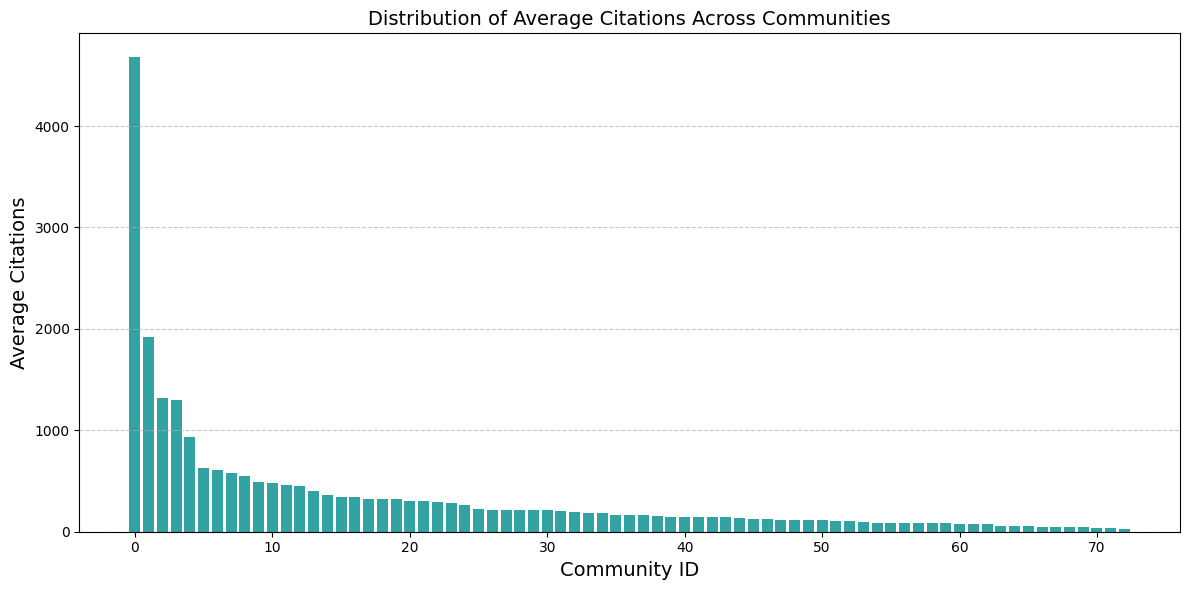

In [35]:
researcher_citations = dict(sorted_researcher_citations)

citations_community_total = {community: 0 for community in communities.keys()}
citations_community_avg = {community: 0 for community in communities.keys()}

for community in communities.keys():
    for node in communities[community]:
        citations_community_total[community] += researcher_citations[node]
    citations_community_avg[community] = citations_community_total[community] / len(communities[community])

# Sort communities by average citations (descending)
sorted_communities_by_avg = sorted(citations_community_avg.items(), key=lambda x: x[1], reverse=True)

# Create a bar plot for average citations per community
plt.figure(figsize=(12, 6))
plt.bar(range(len(citations_community_avg)), 
        [citations for _, citations in sorted_communities_by_avg],
        alpha=0.8,
        color='darkcyan')

plt.title('Distribution of Average Citations Across Communities', fontsize=14)
plt.xlabel('Community ID', fontsize=14)
plt.ylabel('Average Citations', fontsize=14)

# # Add community IDs as x-tick labels
# plt.xticks(range(len(citations_community_avg)), 
#            [community for community, _ in sorted_communities_by_avg],
#            rotation=45)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [36]:
# Sort communities by average citations (descending)
sorted_communities_by_avg = sorted(citations_community_avg.items(), key=lambda x: x[1], reverse=True)

# Print top 5 communities with highest average citations
print("Communities with highest average citation per researcher, descending:")
print("")
for i, (community, avg_citations) in enumerate(sorted_communities_by_avg[:10], 1):
    print(f"{i}. Community {community}: Average Citations: {avg_citations:.2f}")

Communities with highest average citation per researcher, descending:

1. Community 25: Average Citations: 4680.64
2. Community 23: Average Citations: 1922.91
3. Community 2: Average Citations: 1317.72
4. Community 6: Average Citations: 1297.80
5. Community 31: Average Citations: 932.10
6. Community 0: Average Citations: 624.65
7. Community 59: Average Citations: 610.46
8. Community 27: Average Citations: 581.41
9. Community 42: Average Citations: 545.48
10. Community 60: Average Citations: 487.39


**Interpretation:** We find that there is a strong overlap between the communities with highest modularity contribution and the communities with highest average citations per researcher, with communities [6, 23, 25, 2, 0, 31, 60] all being in the top 10 of the two metrics. This means that we have found four commuinities, that are not only working more closely together than all other communities, but produce also more relevant findings. We will further investigate these communities of interest.

Community size on the other hand does not seem to contribute much to this analysis, so we are not investigating it further. 

In [37]:
# List of specific communities to include
communities_of_interest = [25, 23, 2, 6, 31, 0, 60]

# Create a list to store the data for each community
community_data = []

# Gather data for each specified community
for community in communities_of_interest:
    # Get number of nodes in the community
    num_nodes = len(communities[community])
    # Get modularity contribution
    mod_contribution = community_modularity_contribution[community]
    # Get average citations
    avg_citations = citations_community_avg[community]
    
    # Add the data to our list
    community_data.append([
        community,
        num_nodes,
        mod_contribution,
        avg_citations
    ])

# Sort the data by node size in descending order
community_data.sort(key=lambda x: x[3], reverse=True)

# Print the table header
print("-----Identified Communities of Interest-----")
print("")
print(f"{'Community':^10} {'# Nodes':^10} {'Modularity Contr.':^15} {'Avg Citations':^15}")
print("-" * 55)

# Print each row
for data in community_data:
    print(f"{data[0]:^10} {data[1]:^10} {data[2]:^15.4f} {data[3]:^15.2f}")

-----Identified Communities of Interest-----

Community   # Nodes   Modularity Contr.  Avg Citations 
-------------------------------------------------------
    25        608         0.0531          4680.64    
    23        741         0.0702          1922.91    
    2         1053        0.0529          1317.72    
    6         1104        0.1160          1297.80    
    31        1059        0.0112          932.10     
    0         3910        0.0129          624.65     
    60        1375        0.0089          487.39     


____

#### 5.3. Wordclouds for Communities of Interests

In [56]:
# Function to get the abstracts of all papers in one community (no duplicates)
def get_community_abstracts(graph, community_id):
    accessed_papers = set()
    community_abstracts = ""

    for node in communities[community_id]:  # Iterate over nodes in the community
        for _, _, edge_data in graph.edges(node, data=True):  # Access edges and their data
            arxiv_id = edge_data.get('arxivId')  # Retrieve the 'arxivId' from edge data
            abstract = edge_data.get('abstract')  # Retrieve the 'abstract' from edge data
            if arxiv_id and arxiv_id not in accessed_papers:  # Avoid duplicates
                if abstract:
                    community_abstracts += abstract + " "  # Append the abstract
                accessed_papers.add(arxiv_id)  # Mark the paper as accessed
            
    return community_abstracts

In [57]:
# Download stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['n', 'ref', 'url', 'u','jpg','infobox', 'com','https','www','http'])
common_ai_words = ['learning', 'model', 'models', 'task', 'tasks','data','language','performance','methods','method','training']
stop_words.update(common_ai_words)

In [58]:
# Create community dicts and term frequency dicts
communities_dict = {community: get_community_abstracts(RG, community) for community in range(len(communities))}
term_frequency_community = {community: {} for community in communities_dict.keys()}

# Tokenization, filtering, and normalization
for community, text in communities_dict.items():

    tokens = re.findall('[a-zA-Z]+', text.lower())
    filtered_tokens = [word for word in tokens if word not in stop_words]

    term_frequency_community[community]['tokens'] = filtered_tokens
    
    word_freq = FreqDist(filtered_tokens)
    total_tokens = len(filtered_tokens)
    normalized_word_counts = {word: count / total_tokens for word, count in word_freq.items()}
    
    filtered_word_counts = {word: count for word, count in word_freq.items() if count >= 5}
    term_frequency_community[community]['word_count'] = filtered_word_counts
    term_frequency_community[community]['normalized_word_count'] = normalized_word_counts

In [59]:
# Calculate document frequency
doc_freq_dict_cmt = {}
for document in term_frequency_community.keys():
    for word in term_frequency_community[document]['normalized_word_count'].keys():
        if word not in doc_freq_dict_cmt:
            doc_freq_dict_cmt[word] = 0
        doc_freq_dict_cmt[word] += 1

# Calculate IDF
idf_cmt = {}
for word, doc_freq in doc_freq_dict_cmt.items():
    idf_cmt[word] = math.log10(len(term_frequency_community) / doc_freq)

# Calculate TF-IDF
for document in term_frequency_community.keys():
    term_frequency_community[document]['tf_idf'] = {}
    for word, count in term_frequency_community[document]['normalized_word_count'].items():
        tf_idf = count * idf_cmt[word]
        term_frequency_community[document]['tf_idf'][word] = tf_idf

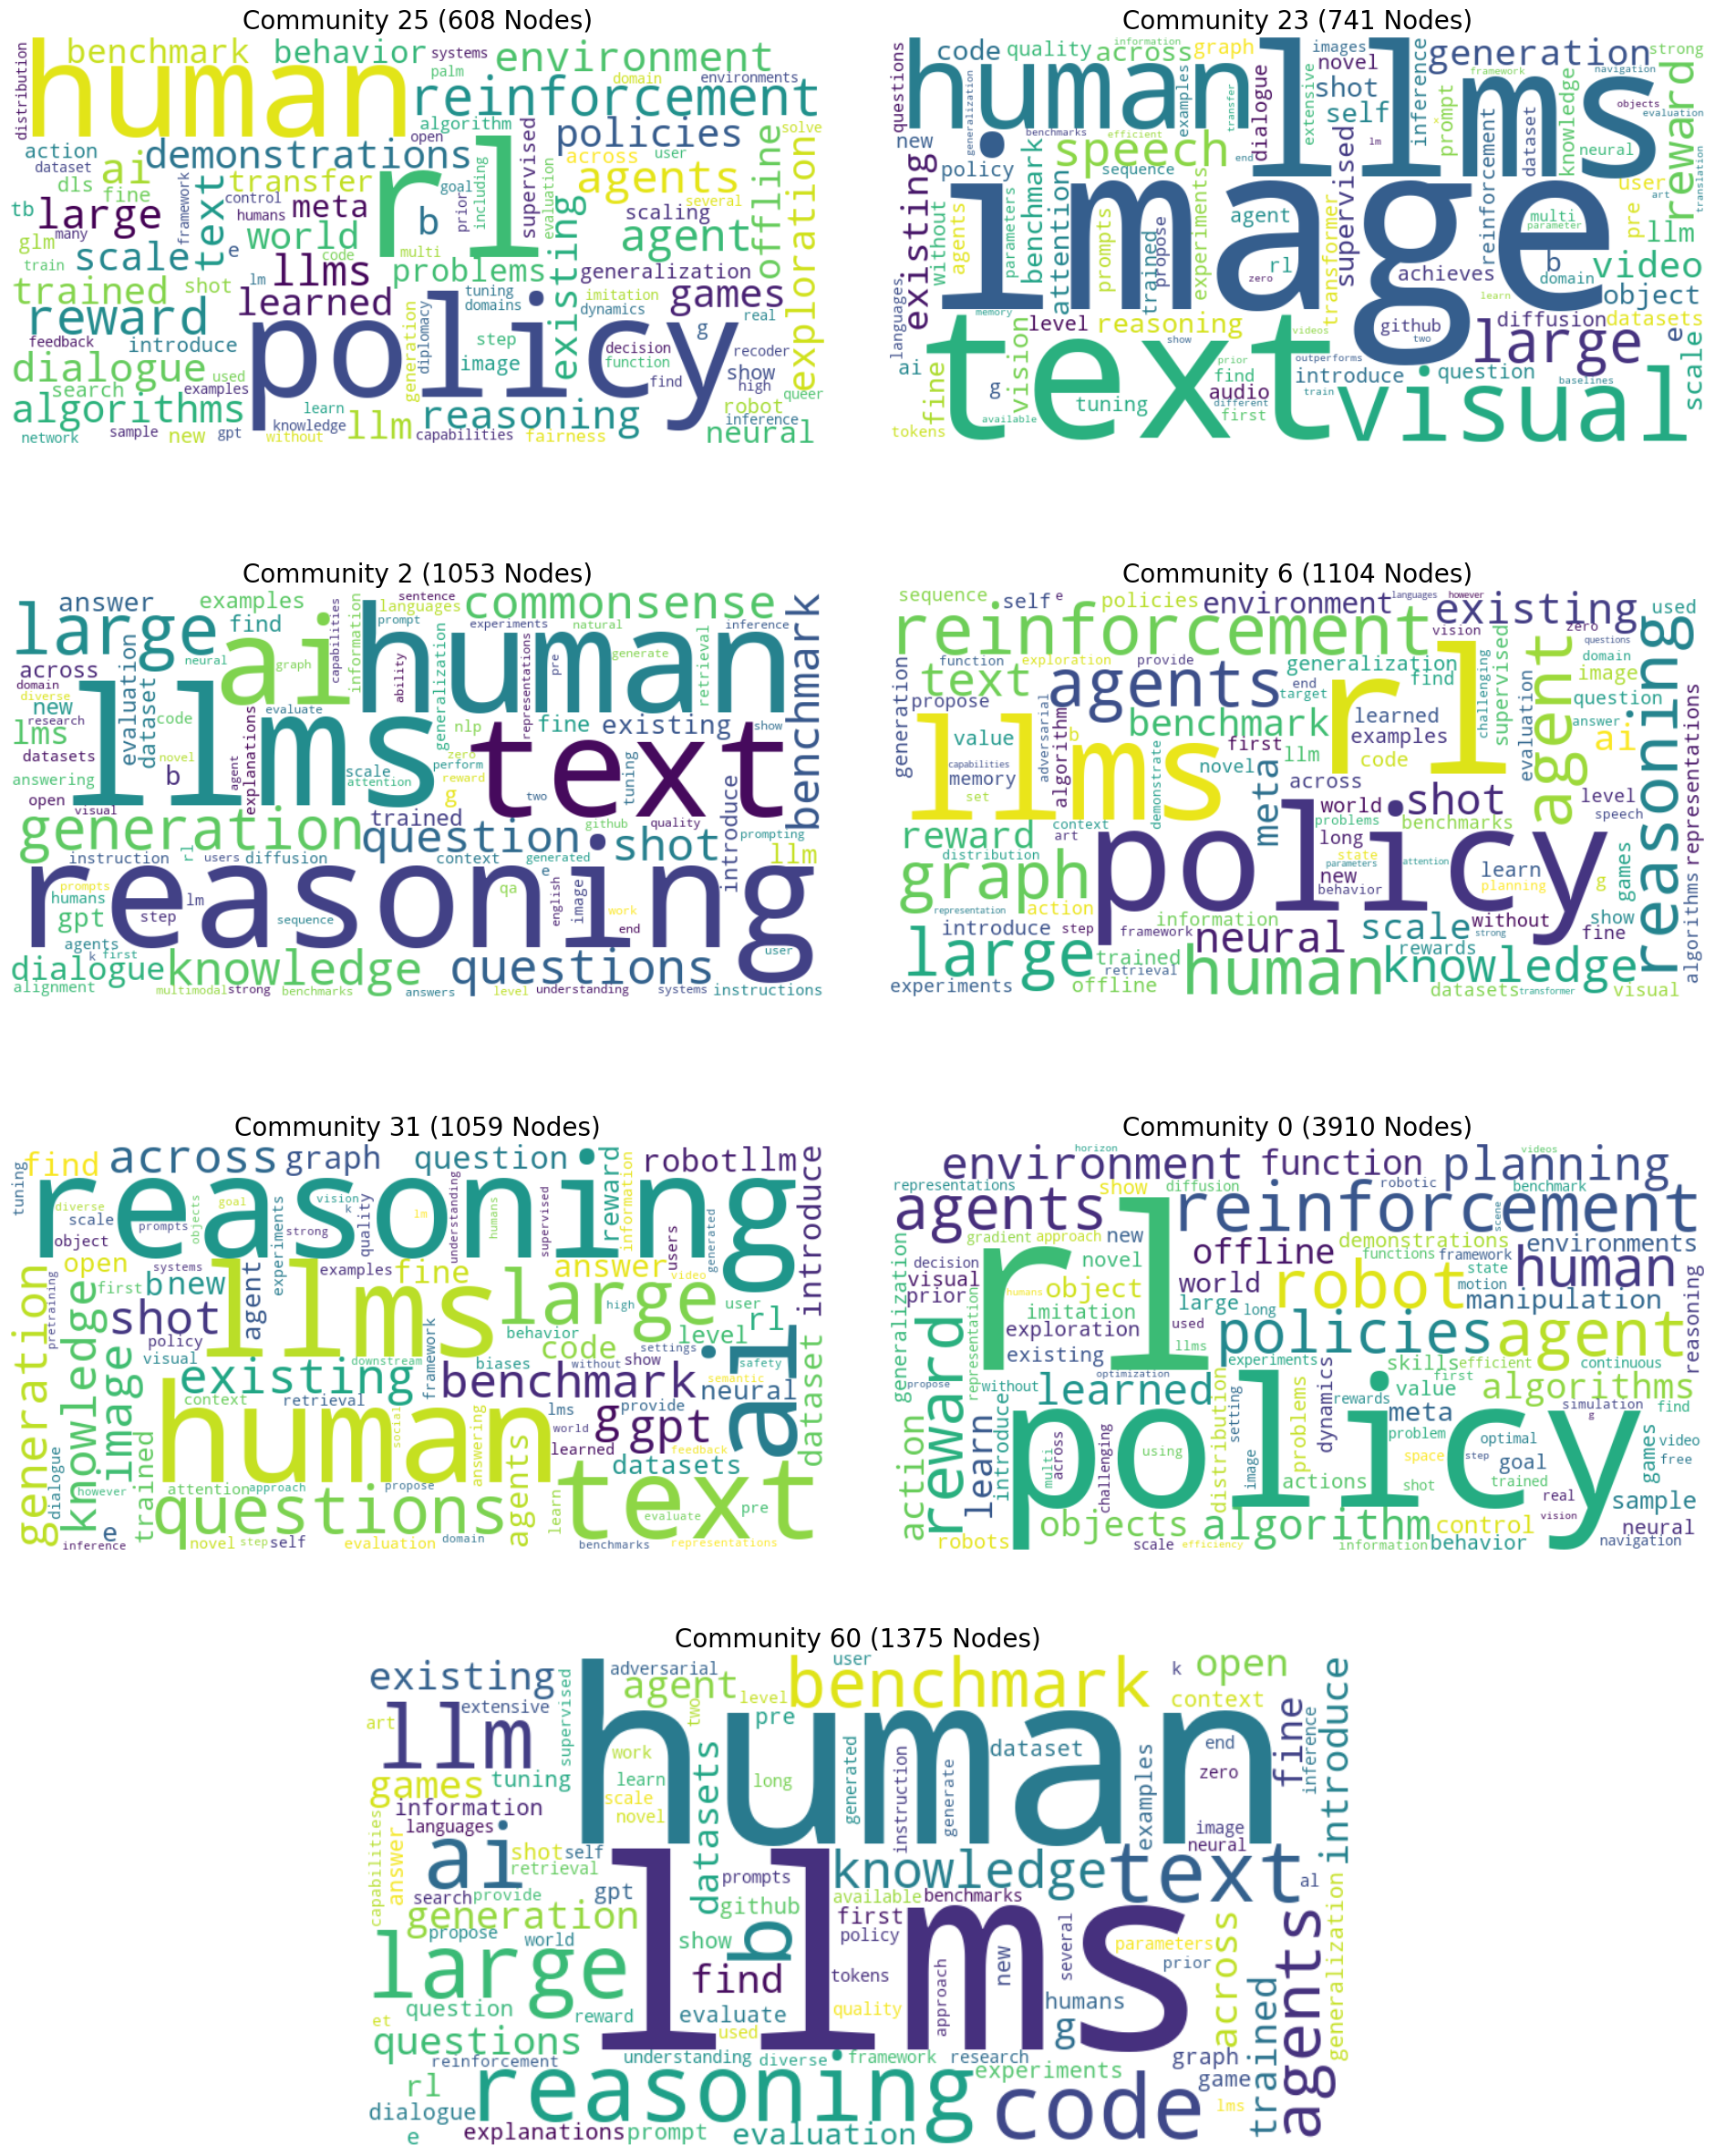

In [60]:
# Set up the word cloud parameters
wordcloud_params = {
    'background_color': 'white',
    'width': 800,
    'height': 400,
    'max_words': 100
}

# Create word clouds only for communities of interest
for community in communities_of_interest:
    if community in term_frequency_community:
        wordcloud = WordCloud(**wordcloud_params).generate_from_frequencies(term_frequency_community[community]['tf_idf'])
        term_frequency_community[community]['wordcloud_tf_idf'] = wordcloud

# Create figure
fig = plt.figure(figsize=(20, 25))  # Adjusted height for 4 rows

# Create gridspec with 4 rows and 2 columns
gs = fig.add_gridspec(4, 2)

# Create axes for the first 6 plots (3 rows x 2 columns)
axes = []
for row in range(3):
    for col in range(2):
        ax = fig.add_subplot(gs[row, col])
        axes.append(ax)

# Create the last plot centered in the bottom row
ax_center = fig.add_subplot(gs[3, :])  # Span both columns
axes.append(ax_center)

# Plot word clouds for communities of interest
for i, community in enumerate(communities_of_interest):
    if community in term_frequency_community and 'wordcloud_tf_idf' in term_frequency_community[community]:
        axes[i].imshow(term_frequency_community[community]['wordcloud_tf_idf'], interpolation='bilinear')
        axes[i].set_title(f'Community {community} ({len(communities[community])} Nodes)', fontsize=20)
        axes[i].axis('off')

plt.tight_layout(pad=5)
plt.show()

<mark>to-do: interpretation</mark>

____

#### 5.4. Researcher Analysis

In [61]:
def get_top_community_researchers(community_id, n=10):
    # Get researchers from specified community
    community_citations = {researcher: citations for researcher, citations in sorted_researcher_citations 
                         if researcher in communities[community_id]}
    
    # Sort by citations and get top n researchers
    top_researchers = dict(sorted(community_citations.items(), 
                                key=lambda x: x[1],
                                reverse=True)[:n])
    
    return top_researchers

In [62]:
def get_top_community_papers(community_id, n=10):
    """
    Get the top n papers by citations for a specific community.
    
    Parameters:
    - community_id: ID of the community to analyze
    - n: Number of top papers to return (default=10)
    
    Returns:
    - Dictionary with paper titles as keys and citation counts as values
    """
    # Get all papers (with citations) that involve researchers from the specified community
    community_papers = {}
    
    # Get researchers from the specified community
    community_researchers = communities[community_id]
    
    # Iterate through all edges in the graph
    for u, v, edge_data in RG.edges(data=True):
        # Check if either researcher is in the community
        if u in community_researchers or v in community_researchers:
            title = edge_data.get('title')
            citations = edge_data.get('numCitedBy', 0)
            
            # Add paper to dictionary if not already present or update with higher citation count
            if title and (title not in community_papers or community_papers[title] < citations):
                community_papers[title] = citations
    
    # Sort papers by citation count and get top n
    sorted_papers = dict(sorted(community_papers.items(), 
                              key=lambda x: x[1], 
                              reverse=True)[:n])
    
    return sorted_papers

In [63]:
def print_community_info(community_id):
    print(f"--------------------------------Community {community_id}--------------------------------")
    print("\nTop 10 Researchers:")
    print("-" *30)
    researchers = get_top_community_researchers(community_id, 10)
    for i, (researcher, citations) in enumerate(researchers.items(), 1):
        print(f"{i}. {researcher} ({citations} citations)")

    print("\nTop 10 Papers:")
    print("-" * 30)
    papers = get_top_community_papers(community_id, 10)
    for i, (paper, citations) in enumerate(papers.items(), 1):
        print(f"{i}. {paper} ({citations} citations)")

**Community 25: OpenAI**

In [64]:
print_community_info(25)

--------------------------------Community 25--------------------------------

Top 10 Researchers:
------------------------------
1. John Schulman (32242 citations)
2. P. Welinder (24595 citations)
3. J. Leike (23320 citations)
4. Wojciech Zaremba (22073 citations)
5. Jeff Wu (21983 citations)
6. Pamela Mishkin (18931 citations)
7. Jie Tang (18874 citations)
8. Chong Zhang (18837 citations)
9. Sandhini Agarwal (18744 citations)
10. Diogo Almeida (18723 citations)

Top 10 Papers:
------------------------------
1. Training language models to follow instructions with human feedback (9614 citations)
2. GPT-4 Technical Report (8972 citations)
3. Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation (6524 citations)
4. Diffusion Models Beat GANs on Image Synthesis (5839 citations)
5. OpenAI Gym (4818 citations)
6. Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments (3973 citations)
7. On the Opportunities and Risks of Foundation

**Community 25: OpenAI**

Community 25 consists entirely of researchers who have worked at OpenAI, including two of the company's co-founders, John Schulmann and Wojciech Zaremba. Currently, 7 out of the 10 researchers continue to work at OpenAI, while 3 have moved on to other ventures - two joined Anthropic and one is in the process of founding a new startup. The most cited papers from this community are closely tied to OpenAI's work, with notable publications including the "GPT-4 Technical Report" and "OpenAI Gym", demonstrating the community's significant contributions to OpenAI's research and development efforts.

**Researcher Portrait: John Schulmann**

John Schulmann is a co-founder of OpenAI and one of the key architects behind some of the company's most significant reinforcement learning algorithms, including PPO (Proximal Policy Optimization). His research has been instrumental in advancing the field of reinforcement learning, with his papers on PPO and TRPO (Trust Region Policy Optimization) being among the most cited works in the domain.

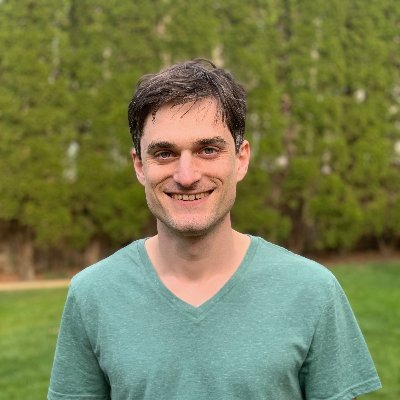

John Schulmann, Co-founder of OpenAI


In [70]:
display(Image('pictures/john_schulmann.jpg', width=300))
print("John Schulmann, Co-founder of OpenAI")


____

**Community 23: Facebook/Meta**

In [67]:
print_community_info(23)

--------------------------------Community 23--------------------------------

Top 10 Researchers:
------------------------------
1. Devi Parikh (33969 citations)
2. Naman Goyal (12541 citations)
3. Angela Fan (12269 citations)
4. Sharan Narang (12210 citations)
5. Vedanuj Goswami (11605 citations)
6. Yuning Mao (11490 citations)
7. Shruti Bhosale (11457 citations)
8. Eric Michael Smith (11325 citations)
9. Sergey Edunov (11083 citations)
10. Madian Khabsa (10892 citations)

Top 10 Papers:
------------------------------
1. Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization (17416 citations)
2. Llama 2: Open Foundation and Fine-Tuned Chat Models (8600 citations)
3. Segment Anything (4678 citations)
4. On the Opportunities and Risks of Foundation Models (3505 citations)
5. Making the V in VQA Matter: Elevating the Role of Image Understanding in Visual Question Answering (2759 citations)
6. HuBERT: Self-Supervised Speech Representation Learning by Masked Predi

**Community 23: Facebook/Meta**

Community 23 is strongly connected to Facebook/Meta, with all ten researchers having worked at the company at some point. Currently, nine of these researchers continue their work at Facebook/Meta, while one member, Devi Parikh, who previously served as Senior Director of GenAI, has departed to pursue entrepreneurial ventures by founding a new startup. The research output from this community closely aligns with Facebook/Meta's initiatives, with significant publications including technical papers about the Llama-2 family of models, demonstrating the community's integral role in the company's AI research and development efforts.

**Researcher Portrait: Devi Parikh**

Devi Parikh is a former Senior Director of GenAI at Facebook/Meta and one of the key architects behind some of the company's most significant reinforcement learning algorithms, including PPO (Proximal Policy Optimization). Her research has been instrumental in advancing the field of reinforcement learning, with her papers on PPO and TRPO (Trust Region Policy Optimization) being among the most cited works in the domain.
display(Image('pictures/devi_parikh.jpg', width=300))
print("Devi Parikh, Senior Director of GenAI at Facebook/Meta")

____

**Community 6: Google/DeepMind**

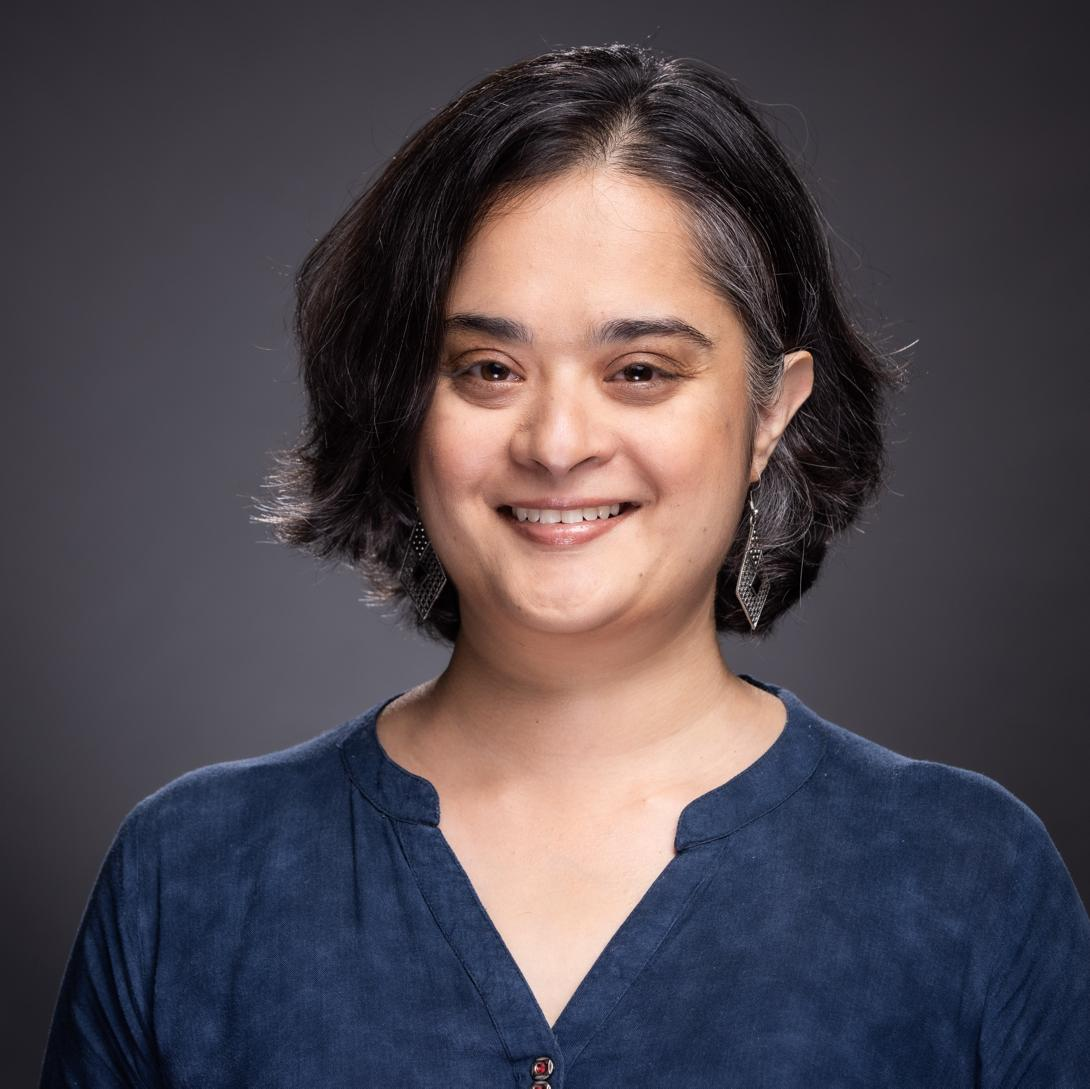

Devi Parikh, former Senior Director of GenAI at Facebook/Meta


In [72]:
display(Image('pictures/devi_parikh.jpg', width=300))
print("Devi Parikh, former Senior Director of GenAI at Facebook/Meta")

____

**Community 6: Google/DeepMind**

In [66]:
print_community_info(6)

--------------------------------Community 6--------------------------------

Top 10 Researchers:
------------------------------
1. N. Houlsby (36510 citations)
2. Mostafa Dehghani (36346 citations)
3. O. Vinyals (19338 citations)
4. Denny Zhou (14610 citations)
5. T. Lillicrap (14094 citations)
6. David Silver (13784 citations)
7. D. Hassabis (13249 citations)
8. Yujia Li (12590 citations)
9. Simon Osindero (12532 citations)
10. Z. Chen (12168 citations)

Top 10 Papers:
------------------------------
1. An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (31414 citations)
2. Conditional Generative Adversarial Nets (9774 citations)
3. GPT-4 Technical Report (8972 citations)
4. Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation (6524 citations)
5. Overcoming catastrophic forgetting in neural networks (6482 citations)
6. Chain of Thought Prompting Elicits Reasoning in Large Language Models (6163 citations)
7. ALBERT: A

**Community 6: Google/DeepMind**

Community 6 represents a highly cohesive group within Google/DeepMind, with all ten researchers having worked at Google, and remarkably, all ten continuing their employment there today. A notable member of this community is Demis Hassabis, who serves as the CEO of DeepMind. The research output from this community strongly reflects Google's AI initiatives, particularly evident in their contributions to papers describing the Gemini family of models. An interesting observation is that one researcher from this community also co-authored the technical report for GPT-4, demonstrating collaboration across major AI organizations.

**Researcher Portrait: Neil Houlsby**

Neil Houlsby is a researcher at Google/DeepMind and one of the key architects behind some of the company's most significant reinforcement learning algorithms, including PPO (Proximal Policy Optimization). His research has been instrumental in advancing the field of reinforcement learning, with his papers on PPO and TRPO (Trust Region Policy Optimization) being among the most cited works in the domain.


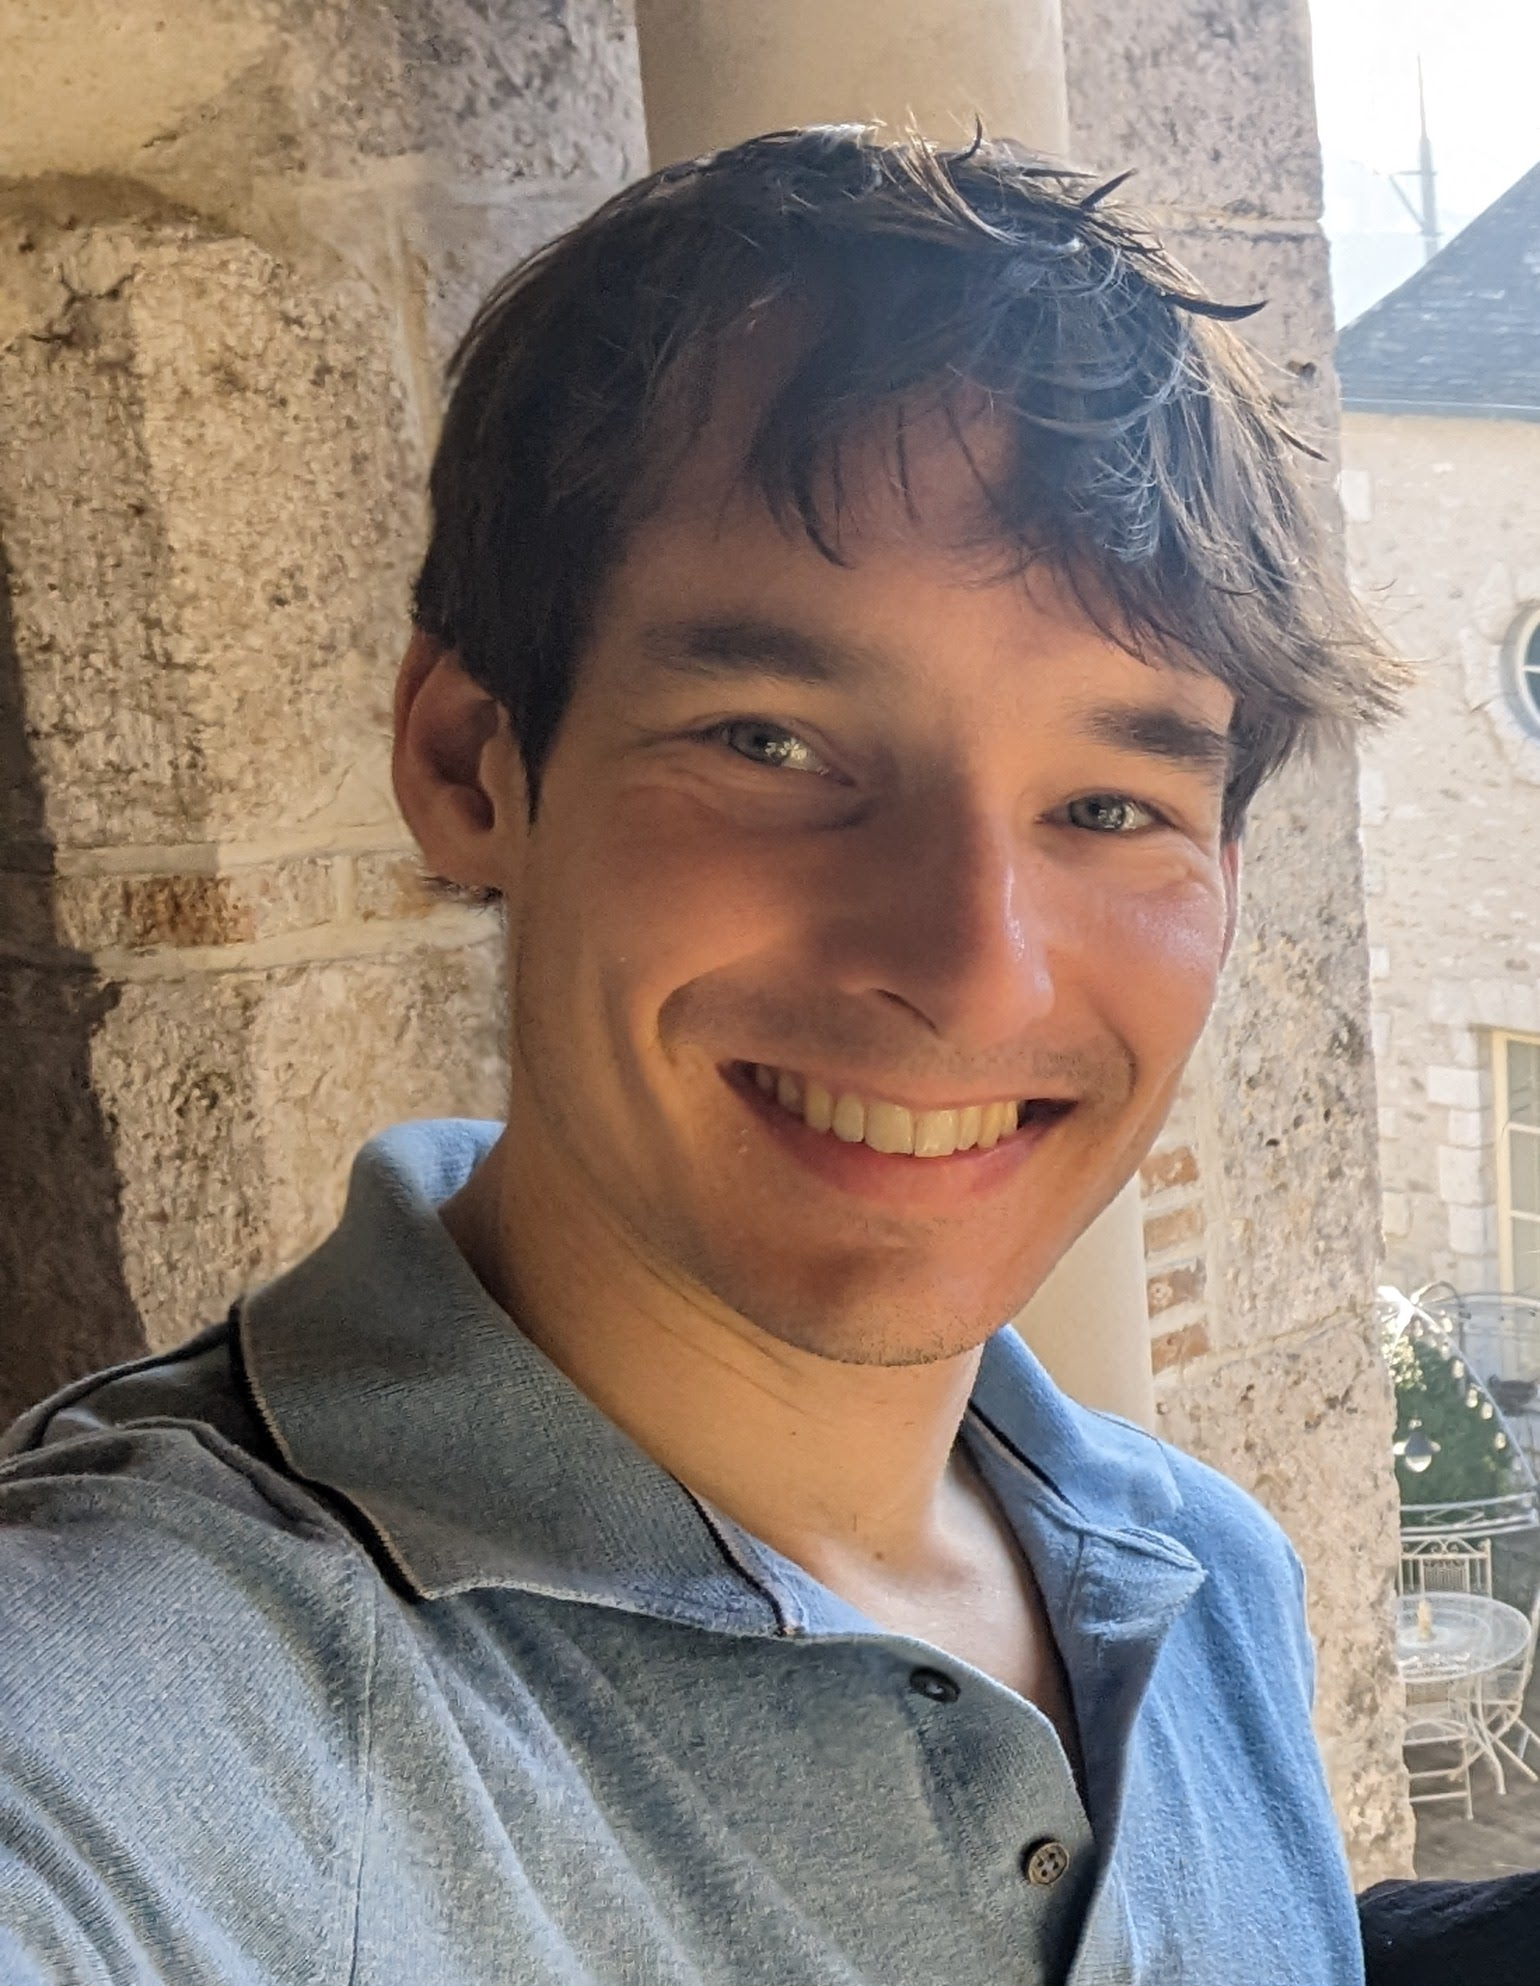

Neil Houlsby, Researcher at Google/DeepMind


In [73]:
display(Image('pictures/neil_houlsby.jpg', width=300))
print("Neil Houlsby, Researcher at Google/DeepMind")

## 8. Visualizing the graph

After having gained an understanding of the nodes and edges in our graph, we want to visualize the graph. To do that we are implementing a disparity filter according to the method described in the [Extracting the multiscale backbone of complex weighted networks](https://arxiv.org/abs/0904.2389) paper.


In [39]:
def disparity_filter(graph, alpha=0.1):
    """
    Apply the disparity filter to a weighted graph using the statistical p-value-based method.

    Parameters:
    - graph: The input weighted graph (NetworkX Graph).
    - alpha: The significance level to filter edges.

    Returns:
    - filtered_graph: A new graph containing only the significant edges (filtered backbone).
    """
    filtered_edges = []
    
    for node in graph.nodes:
        neighbors = list(graph.neighbors(node))
        k_i = len(neighbors)  # Degree of the node
        if k_i < 2:
            continue  # Skip nodes with degree < 2
        
        total_weight = sum(graph[node][neighbor]['weight'] for neighbor in neighbors)
        
        # Skip nodes with zero total weight
        if total_weight == 0:
            continue
        
        for neighbor in neighbors:
            w_ij = graph[node][neighbor]['weight']
            p_ij = w_ij / total_weight
            
            # Compute p-value α_ij = (1 - p_ij)^(k_i - 1)
            alpha_ij = (1 - p_ij) ** (k_i - 1)
            
            # Keep edge if α_ij <= alpha
            if alpha_ij <= alpha:
                filtered_edges.append((node, neighbor, w_ij))
    
    # Create a subgraph with the filtered edges
    filtered_graph = nx.Graph()
    filtered_graph.add_weighted_edges_from(filtered_edges)
    
    return filtered_graph

In [40]:
backbone_disparity = disparity_filter(weighted_RG)

connected_components = list(nx.connected_components(backbone_disparity))

# Identify the largest connected component (the giant component)
giant_component = max(connected_components, key=len)

# Create a subgraph for the giant component
backbone_disparity_gcc = backbone_disparity.subgraph(giant_component).copy()

In [41]:
num_nodes_weighted_RG = len(weighted_RG.nodes)
num_edges_weighted_RG = len(weighted_RG.edges)

num_nodes_filtered_backbone = len(backbone_disparity_gcc.nodes)
num_edges_filtered_backbone = len(backbone_disparity_gcc.edges)

print(f"Summary of weighted_RG graph:")
print(f"Number of nodes: {num_nodes_weighted_RG}")
print(f"Number of edges: {num_edges_weighted_RG}")

print(f"\nSummary of filtered_backbone graph:")
print(f"Number of nodes: {num_nodes_filtered_backbone}")
print(f"Number of edges: {num_edges_filtered_backbone}")

Summary of weighted_RG graph:
Number of nodes: 39314
Number of edges: 942607

Summary of filtered_backbone graph:
Number of nodes: 8531
Number of edges: 26364


The graph has been significantly filtered down to include only the most relevant part of the network. To finalize the preparation for plotting we use ForceAtlas2 layout to figure out the positioning of each node for aesthetic appeal.

In [ ]:
# Prepare ForceAtlas2 layout
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade clustering
    linLogMode=False,                     # Force linear distance scale
    adjustSizes=False,                    # Leave node sizes as-is
    edgeWeightInfluence=2.0,              # Equal influence of edges
    jitterTolerance=1.0,                  # Stabilize layout
    barnesHutOptimize=True,               # Optimization for large graphs
    barnesHutTheta=1.2,                   # Controls "accuracy" vs. speed
    scalingRatio=2.0,                     # Space out clusters
    strongGravityMode=False,              # Standard gravity
    gravity=1.0,                          # Overall pull towards center
    verbose=True                          # Verbose output for process tracking
)

# Results have been commented out as it takes long to run
# positions_backbone_disparity = forceatlas2.forceatlas2_networkx_layout(backbone_disparity_gcc, pos=None, iterations=1000)

# with open("positions_backbone_disparity.pkl", "wb") as file:
#     pickle.dump(positions_backbone_disparity, file)

In [ ]:
# Once processed and saved the positioning can be loaded with this
with open("pickles/positions_backbone_disparity.pkl", "rb") as file:
    positions_backbone_disparity = pickle.load(file)

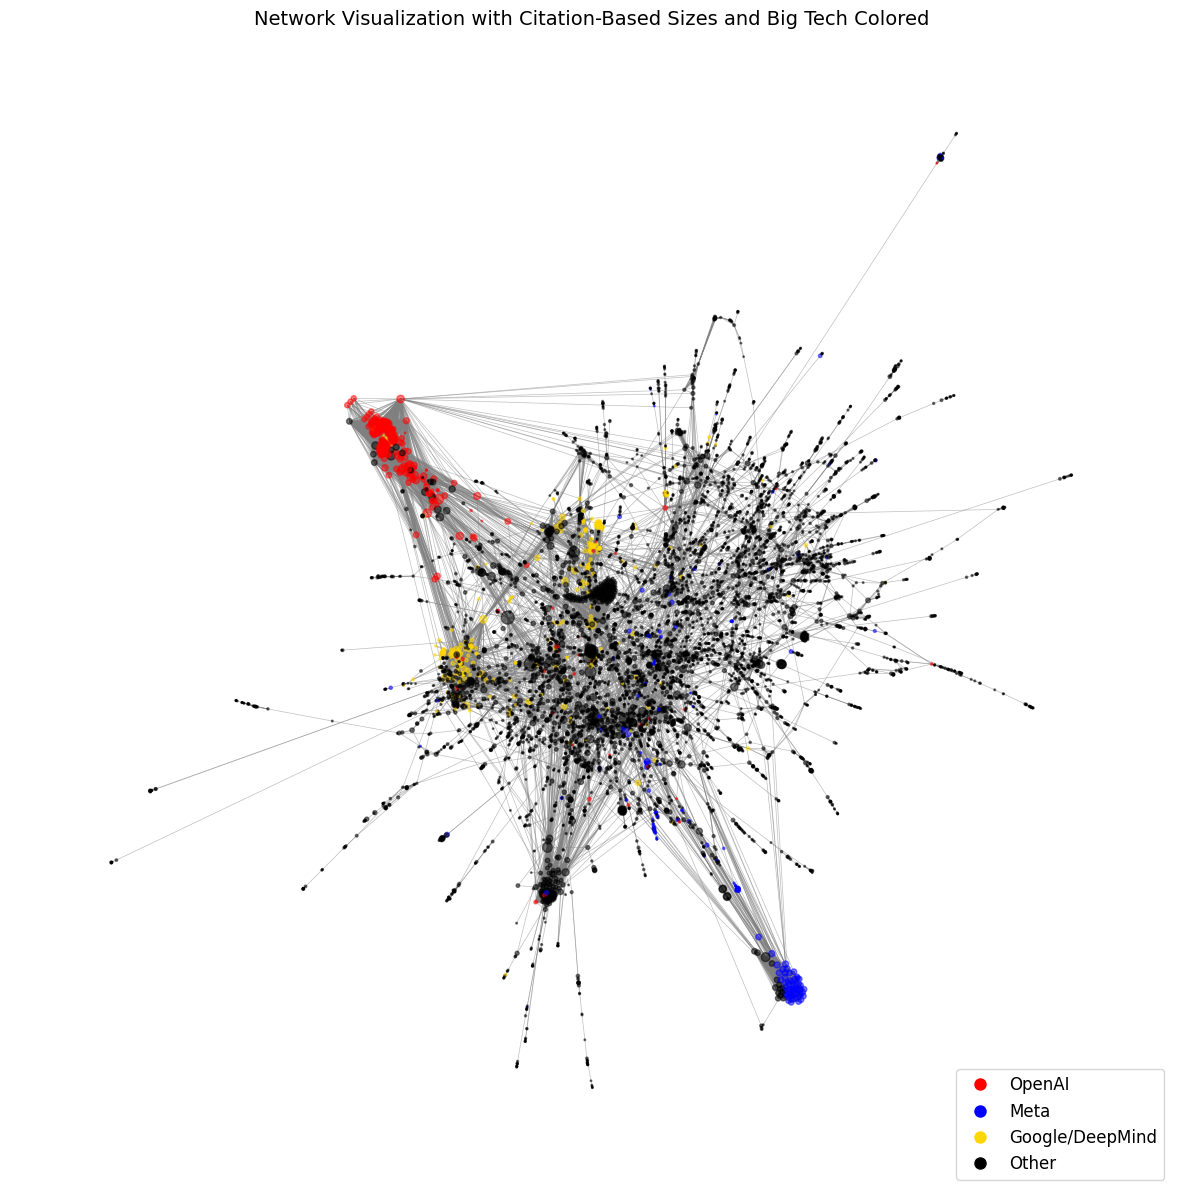

In [51]:
# Node sizes based on citations
min_size, max_size = 1, 100
citations = [researcher_citations.get(node, 0) for node in backbone_disparity_gcc.nodes]
if max(citations) > 0:  # Avoid division by zero
    node_sizes = [min_size + (max_size - min_size) * (citation / max(citations)) for citation in citations]
else:
    node_sizes = [min_size for _ in backbone_disparity_gcc.nodes]

# Node colors based on community labels
community_colors = {25: "red", 23: "blue", 6: "gold"}  # Define the colors for specific communities
node_colors = []

for node in backbone_disparity_gcc.nodes:
    # Find the community label of the node
    community_label = None
    for label, members in communities.items():
        if node in members:
            community_label = label
            break
    
    # Assign color based on community label
    if community_label in community_colors:
        node_colors.append(community_colors[community_label])
    else:
        node_colors.append("black")  # Default to black for other communities

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(
    backbone_disparity_gcc,
    pos=positions_backbone_disparity,
    node_size=node_sizes,  # Citation-based sizes
    edge_color="grey",
    node_color=node_colors,  # Community-based colors
    width=0.5,
    alpha=0.5,
    ax=ax
)

# Creating custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='OpenAI'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Meta'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', markersize=10, label='Google/DeepMind'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Other')
]

# Add the legend to the plot
plt.legend(handles=legend_elements, loc='lower right', fontsize=12)

# Set the title and show the plot
plt.title("Network Visualization with Citation-Based Sizes and Big Tech Colored", fontsize=14)
plt.show()

Viusalization shows the most significant part of the network. Each node represents a researcher with size growing with the number of citations. Three communities from Big Tech have been colored as described in the legend. Previousely detected communities of researchers from OpenAI, Meta and Google/DeepMind are clearly close to each other. The Google researchers seem to be the most spread out among all three however still relatively close.

C:\Users\balda\AppData\Local\Temp\ipykernel_19544\3139559354.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(community_labels))  # Use 'tab20' for distinct colors


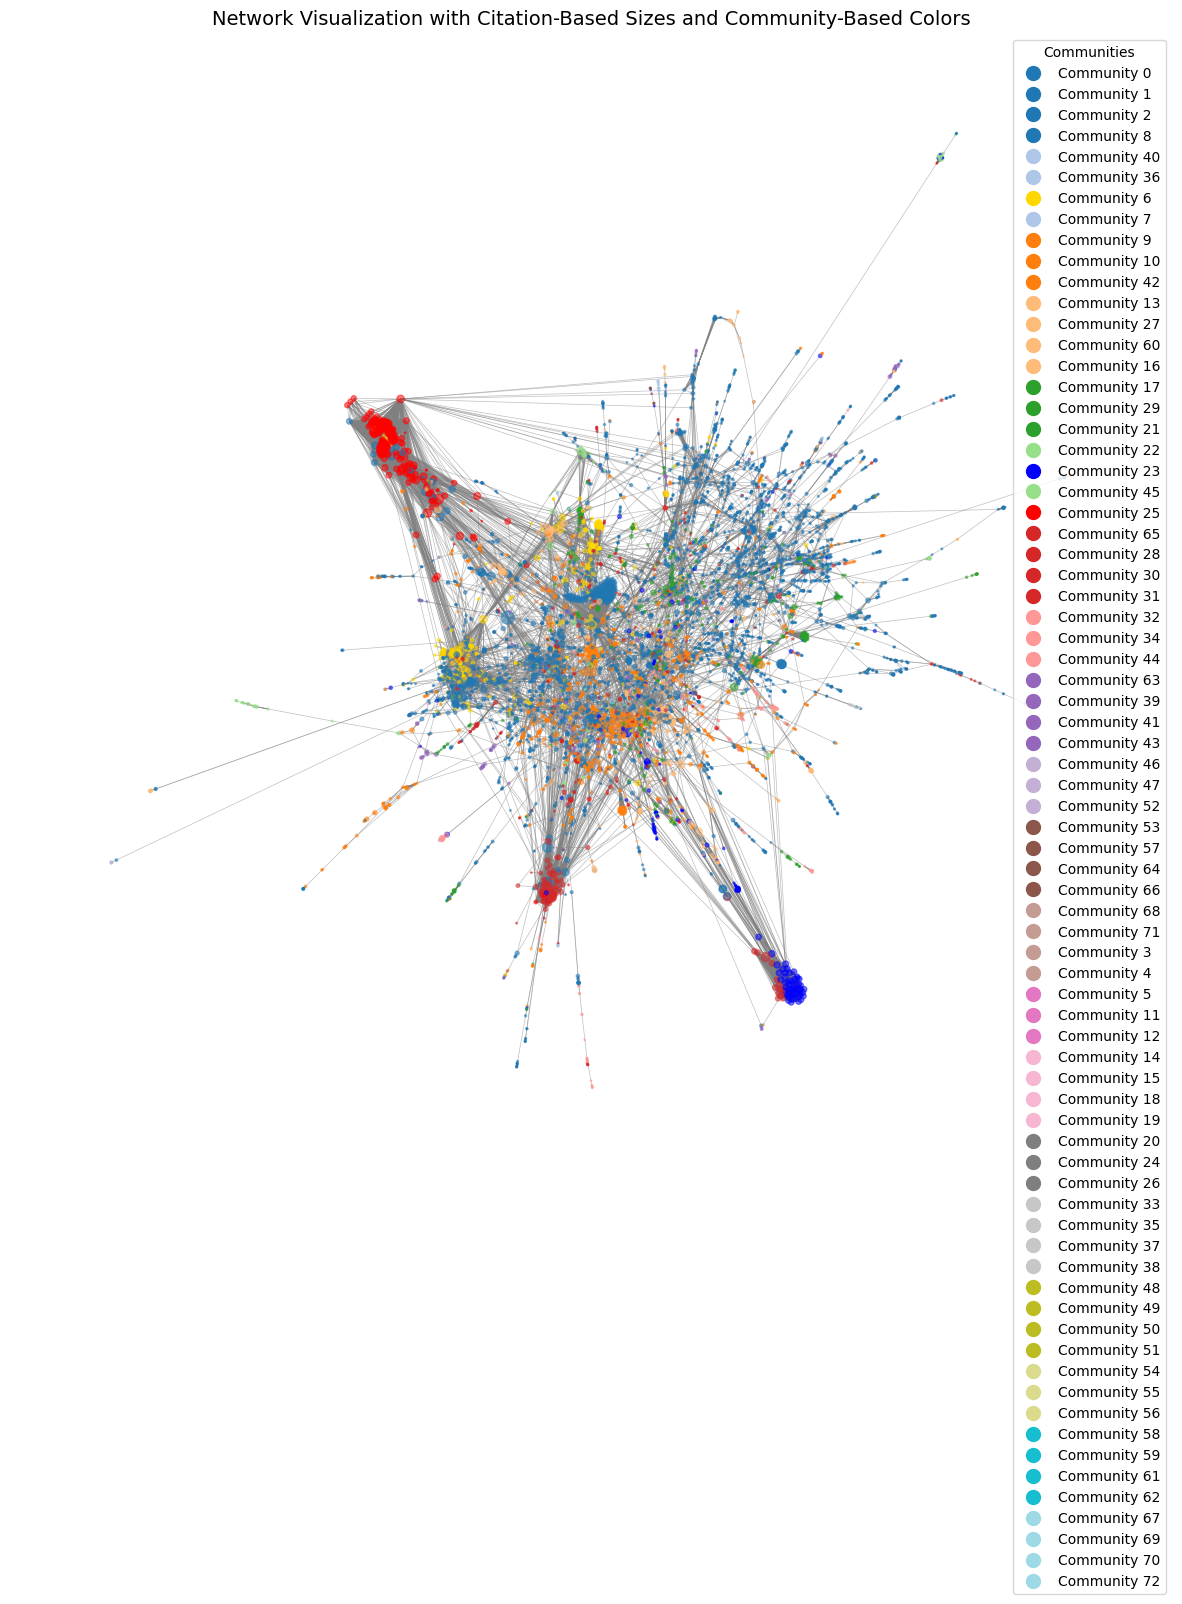

In [47]:
# Generate a distinct color for each community
community_labels = list(communities.keys())  # Get all community labels
cmap = cm.get_cmap('tab20', len(community_labels))  # Use 'tab20' for distinct colors

# Assign a color for each community, overriding specific communities with custom colors
custom_colors = {25: "red", 23: "blue", 6: "gold"}  # Define custom colors for specific communities
community_colors = {label: custom_colors.get(label, mcolors.to_hex(cmap(i))) for i, label in enumerate(community_labels)}

# Assign node colors based on their community
node_colors = []
for node in backbone_disparity_gcc.nodes:
    # Find the community label of the node
    community_label = None
    for label, members in communities.items():
        if node in members:
            community_label = label
            break
    
    # Assign the color based on the community label
    if community_label is not None:
        node_colors.append(community_colors[community_label])
    else:
        node_colors.append("black")  # Default to black if no community is found

# Node sizes based on citations
min_size, max_size = 1, 100
citations = [researcher_citations.get(node, 0) for node in backbone_disparity_gcc.nodes]
if max(citations) > 0:  # Avoid division by zero
    node_sizes = [min_size + (max_size - min_size) * (citation / max(citations)) for citation in citations]
else:
    node_sizes = [min_size for _ in backbone_disparity_gcc.nodes]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(
    backbone_disparity_gcc,
    pos=positions_backbone_disparity,
    node_size=node_sizes,  # Citation-based sizes
    edge_color="grey",
    node_color=node_colors,  # Community-based colors
    width=0.5,
    alpha=0.5,
    ax=ax
)

# Add a legend for the communities
handles = [plt.Line2D([0], [0], marker='o', color=community_colors[label], linestyle='', markersize=10) for label in community_labels]
labels = [f'Community {label}' for label in community_labels]
ax.legend(handles, labels, loc='upper right', title="Communities")

# Set the title and show the plot
plt.title("Network Visualization with Citation-Based Sizes and Community-Based Colors", fontsize=14)
plt.show()

Finally, we have the visualization of all the detected communities. One can visual identify that a lot of them do in fact form close "clusters" but since the number of communities is large the analysis of this visualization is hard.